In [30]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

## Dataset, DataLoader

- fashion mnist data label


- 0: "T-shirt/Top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat", 
5: "Sandal", 
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle Boot"

In [31]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../data/fashionmnist/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values #데이터프레임의 label열을 array 형식으로 반환
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx]) # NumPy 배열에서 PIL(Python Imaging Library) 이미지 객체를 생성
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [32]:
dataset = FashionMNIST()
dataset[0][0]

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [34]:
img, label = dataset.__getitem__(1)
print(img.size(), label)

torch.Size([1, 28, 28]) 9


## CGAN
- Conditional GAN

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [36]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        
        #x.size(0) == batch size
        return out.view(x.size(0), 28, 28)

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [38]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [39]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [40]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    
    #noise 생성
    z = torch.randn(batch_size, 100, device=device)
    
    #fake labels, images 생성
    fake_labels = torch.randint(0, 10, (batch_size,), device=device)
    fake_images = generator(z, fake_labels)
    
    # D(fake images)
    validity = discriminator(fake_images, fake_labels)
    
    #Generator의 목표 : D(G(z)) = 1 이므로 loss(D(G(z)), 1)
    g_loss = criterion(validity, torch.ones(batch_size, device=device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()


In [41]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size, device=device))

    # Train with fake images
    z = torch.randn(batch_size, 100, device=device)
    fake_labels = torch.randint(0, 10, (batch_size,), device=device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size, device=device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()


**Generator, Discriminator 학습**
- 학습시키는데 GPU기준 약 10분 소요

Starting epoch 0...
Step [0/938], d_loss: 0.4899, g_loss: 0.2623
Step [100/938], d_loss: 0.0223, g_loss: 0.7705
Step [200/938], d_loss: 0.0007, g_loss: 0.9601
Step [300/938], d_loss: 0.0006, g_loss: 0.9773
Step [400/938], d_loss: 0.0001, g_loss: 0.9888
Step [500/938], d_loss: 0.0000, g_loss: 0.9973
Step [600/938], d_loss: 0.0001, g_loss: 0.9969
Step [700/938], d_loss: 0.0000, g_loss: 0.9982
Step [800/938], d_loss: 0.0002, g_loss: 1.0000
Step [900/938], d_loss: 0.0002, g_loss: 0.9944
Epoch [0/30], d_loss: 0.0000, g_loss: 1.0000


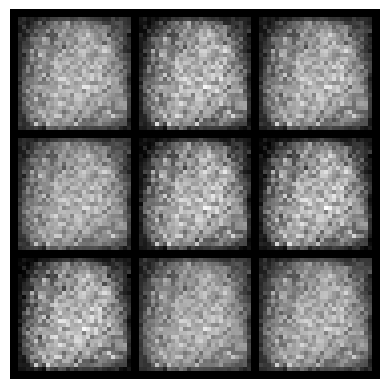

Starting epoch 1...
Step [0/938], d_loss: 0.0001, g_loss: 0.9999
Step [100/938], d_loss: 0.0145, g_loss: 0.9907
Step [200/938], d_loss: 0.0000, g_loss: 0.9894
Step [300/938], d_loss: 0.0000, g_loss: 0.9997
Step [400/938], d_loss: 0.0002, g_loss: 0.9842
Step [500/938], d_loss: 0.0001, g_loss: 0.9938
Step [600/938], d_loss: 0.0001, g_loss: 0.9944
Step [700/938], d_loss: 0.0000, g_loss: 0.9991
Step [800/938], d_loss: 0.0002, g_loss: 0.9911
Step [900/938], d_loss: 0.0000, g_loss: 0.9991
Epoch [1/30], d_loss: 0.0312, g_loss: 0.9998


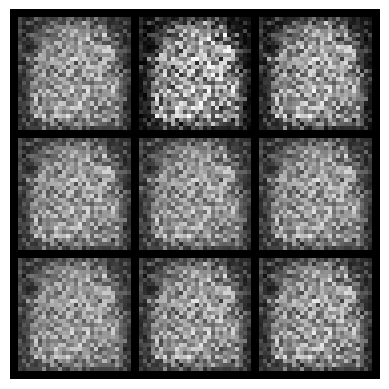

Starting epoch 2...
Step [0/938], d_loss: 0.0000, g_loss: 0.9996
Step [100/938], d_loss: 0.0001, g_loss: 0.9971
Step [200/938], d_loss: 0.0000, g_loss: 0.9970
Step [300/938], d_loss: 0.0000, g_loss: 0.9997
Step [400/938], d_loss: 0.0000, g_loss: 0.9993
Step [500/938], d_loss: 0.0000, g_loss: 1.0000
Step [600/938], d_loss: 0.0000, g_loss: 0.9999
Step [700/938], d_loss: 0.0000, g_loss: 0.9987
Step [800/938], d_loss: 0.0000, g_loss: 0.9999
Step [900/938], d_loss: 0.0000, g_loss: 0.9989
Epoch [2/30], d_loss: 0.0000, g_loss: 0.9970


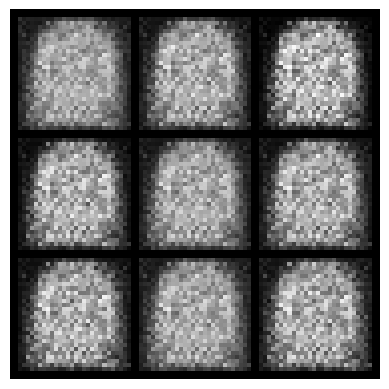

Starting epoch 3...
Step [0/938], d_loss: 0.0000, g_loss: 0.9926
Step [100/938], d_loss: 0.0000, g_loss: 0.9969
Step [200/938], d_loss: 0.0000, g_loss: 0.9988
Step [300/938], d_loss: 0.0002, g_loss: 0.9995
Step [400/938], d_loss: 0.0000, g_loss: 1.0000
Step [500/938], d_loss: 0.0000, g_loss: 0.9995
Step [600/938], d_loss: 0.0000, g_loss: 0.9984
Step [700/938], d_loss: 0.0000, g_loss: 0.9998
Step [800/938], d_loss: 0.0000, g_loss: 0.9982
Step [900/938], d_loss: 0.0001, g_loss: 0.9968
Epoch [3/30], d_loss: 0.0000, g_loss: 0.9588


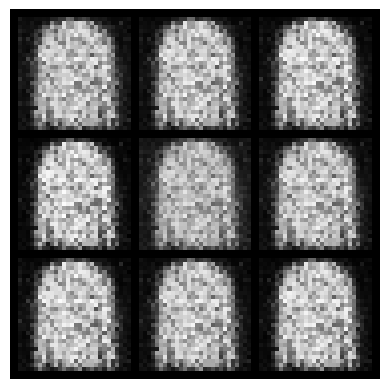

Starting epoch 4...
Step [0/938], d_loss: 0.0288, g_loss: 1.0000
Step [100/938], d_loss: 0.0001, g_loss: 0.9995
Step [200/938], d_loss: 0.0000, g_loss: 0.9999
Step [300/938], d_loss: 0.0000, g_loss: 0.9982
Step [400/938], d_loss: 0.0000, g_loss: 0.9997
Step [500/938], d_loss: 0.0001, g_loss: 0.9991
Step [600/938], d_loss: 0.0048, g_loss: 0.9997
Step [700/938], d_loss: 0.0000, g_loss: 0.9998
Step [800/938], d_loss: 0.0022, g_loss: 1.0000
Step [900/938], d_loss: 0.0001, g_loss: 0.9985
Epoch [4/30], d_loss: 0.0000, g_loss: 0.9995


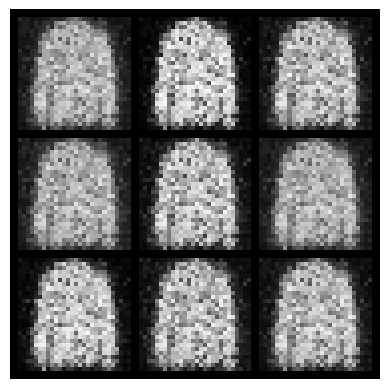

Starting epoch 5...
Step [0/938], d_loss: 0.0000, g_loss: 0.9998
Step [100/938], d_loss: 0.0056, g_loss: 1.0000
Step [200/938], d_loss: 0.0000, g_loss: 1.0000
Step [300/938], d_loss: 0.0001, g_loss: 0.9949
Step [400/938], d_loss: 0.0000, g_loss: 1.0000
Step [500/938], d_loss: 0.0000, g_loss: 0.9793
Step [600/938], d_loss: 0.0000, g_loss: 0.9917
Step [700/938], d_loss: 0.0002, g_loss: 0.9984
Step [800/938], d_loss: 0.0000, g_loss: 0.9933
Step [900/938], d_loss: 0.0000, g_loss: 0.9995
Epoch [5/30], d_loss: 0.0000, g_loss: 1.0000


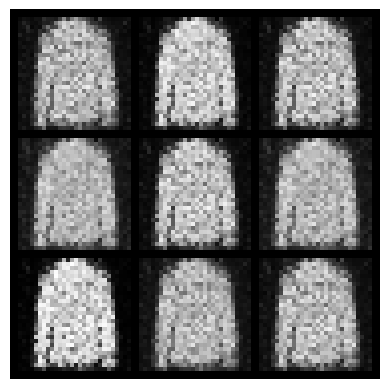

Starting epoch 6...
Step [0/938], d_loss: 0.0001, g_loss: 0.9995
Step [100/938], d_loss: 0.0000, g_loss: 0.9976
Step [200/938], d_loss: 0.0003, g_loss: 1.0000
Step [300/938], d_loss: 0.0000, g_loss: 0.9985
Step [400/938], d_loss: 0.0000, g_loss: 0.9977
Step [500/938], d_loss: 0.0000, g_loss: 1.0000
Step [600/938], d_loss: 0.0001, g_loss: 0.9996
Step [700/938], d_loss: 0.0639, g_loss: 1.0000
Step [800/938], d_loss: 0.0120, g_loss: 0.9833
Step [900/938], d_loss: 0.0000, g_loss: 0.9994
Epoch [6/30], d_loss: 0.0000, g_loss: 0.9963


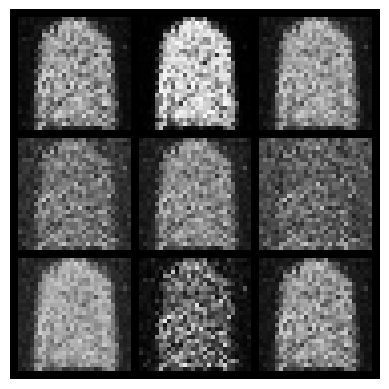

Starting epoch 7...
Step [0/938], d_loss: 0.0003, g_loss: 0.9995
Step [100/938], d_loss: 0.0002, g_loss: 0.9864
Step [200/938], d_loss: 0.0000, g_loss: 0.9995
Step [300/938], d_loss: 0.0009, g_loss: 0.9959
Step [400/938], d_loss: 0.0000, g_loss: 0.9999
Step [500/938], d_loss: 0.0000, g_loss: 0.9997
Step [600/938], d_loss: 0.0000, g_loss: 0.9668
Step [700/938], d_loss: 0.0005, g_loss: 0.9840
Step [800/938], d_loss: 0.0000, g_loss: 1.0000
Step [900/938], d_loss: 0.0000, g_loss: 1.0000
Epoch [7/30], d_loss: 0.0000, g_loss: 0.9992


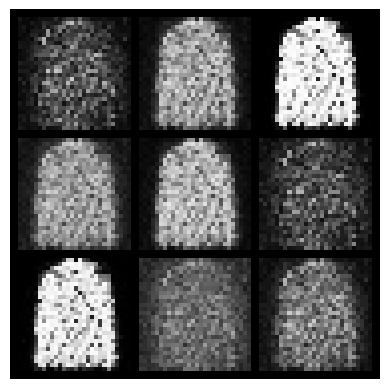

Starting epoch 8...
Step [0/938], d_loss: 0.0000, g_loss: 0.9999
Step [100/938], d_loss: 0.0000, g_loss: 0.9999
Step [200/938], d_loss: 0.0000, g_loss: 0.9996
Step [300/938], d_loss: 0.0001, g_loss: 0.9993
Step [400/938], d_loss: 0.0017, g_loss: 1.0000
Step [500/938], d_loss: 0.0000, g_loss: 0.9994
Step [600/938], d_loss: 0.0000, g_loss: 0.9999
Step [700/938], d_loss: 0.0000, g_loss: 0.9999
Step [800/938], d_loss: 0.0001, g_loss: 0.9905
Step [900/938], d_loss: 0.0257, g_loss: 1.0000
Epoch [8/30], d_loss: 0.0001, g_loss: 0.9991


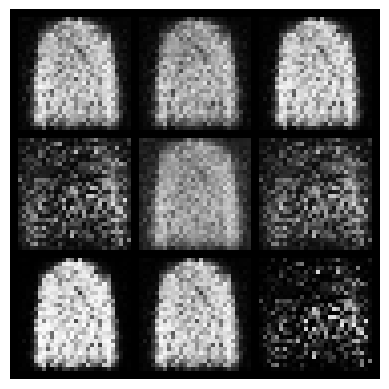

Starting epoch 9...
Step [0/938], d_loss: 0.0000, g_loss: 0.9999
Step [100/938], d_loss: 0.0000, g_loss: 0.9991
Step [200/938], d_loss: 0.0000, g_loss: 0.9975
Step [300/938], d_loss: 0.0050, g_loss: 0.9910
Step [400/938], d_loss: 0.0000, g_loss: 0.9991
Step [500/938], d_loss: 0.0094, g_loss: 0.9998
Step [600/938], d_loss: 0.0006, g_loss: 0.9952
Step [700/938], d_loss: 0.0000, g_loss: 0.9975
Step [800/938], d_loss: 0.0000, g_loss: 0.9913
Step [900/938], d_loss: 0.0005, g_loss: 0.9997
Epoch [9/30], d_loss: 0.0278, g_loss: 0.9997


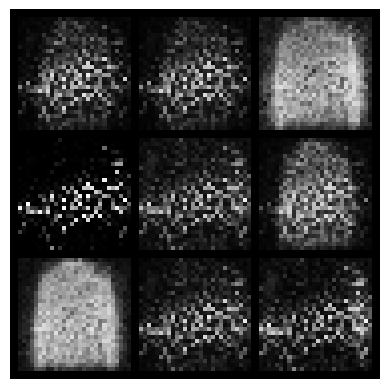

Starting epoch 10...
Step [0/938], d_loss: 0.0033, g_loss: 0.9992
Step [100/938], d_loss: 0.0110, g_loss: 0.9837
Step [200/938], d_loss: 0.0002, g_loss: 0.9997
Step [300/938], d_loss: 0.0002, g_loss: 0.9999
Step [400/938], d_loss: 0.0000, g_loss: 0.9971
Step [500/938], d_loss: 0.0002, g_loss: 0.9998
Step [600/938], d_loss: 0.0055, g_loss: 0.9963
Step [700/938], d_loss: 0.0054, g_loss: 0.9992
Step [800/938], d_loss: 0.0658, g_loss: 0.9997
Step [900/938], d_loss: 0.0426, g_loss: 0.9976
Epoch [10/30], d_loss: 0.0000, g_loss: 0.9990


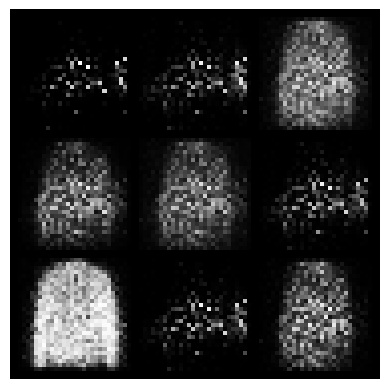

Starting epoch 11...
Step [0/938], d_loss: 0.0203, g_loss: 0.9622
Step [100/938], d_loss: 0.0119, g_loss: 0.9942
Step [200/938], d_loss: 0.0002, g_loss: 0.9926
Step [300/938], d_loss: 0.0065, g_loss: 0.9786
Step [400/938], d_loss: 0.0805, g_loss: 0.9825
Step [500/938], d_loss: 0.0000, g_loss: 0.9980
Step [600/938], d_loss: 0.0235, g_loss: 0.9879
Step [700/938], d_loss: 0.0865, g_loss: 0.9996
Step [800/938], d_loss: 0.0154, g_loss: 0.9943
Step [900/938], d_loss: 0.0024, g_loss: 0.9989
Epoch [11/30], d_loss: 0.0000, g_loss: 0.9995


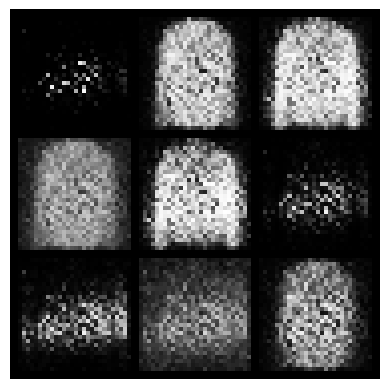

Starting epoch 12...
Step [0/938], d_loss: 0.0010, g_loss: 0.9995
Step [100/938], d_loss: 0.0013, g_loss: 0.9960
Step [200/938], d_loss: 0.0042, g_loss: 0.9962
Step [300/938], d_loss: 0.2170, g_loss: 0.9740
Step [400/938], d_loss: 0.0245, g_loss: 0.9878
Step [500/938], d_loss: 0.0018, g_loss: 0.9908
Step [600/938], d_loss: 0.0040, g_loss: 0.9598
Step [700/938], d_loss: 0.0038, g_loss: 0.9895
Step [800/938], d_loss: 0.0101, g_loss: 0.9856
Step [900/938], d_loss: 0.0447, g_loss: 0.9987
Epoch [12/30], d_loss: 0.0135, g_loss: 0.9958


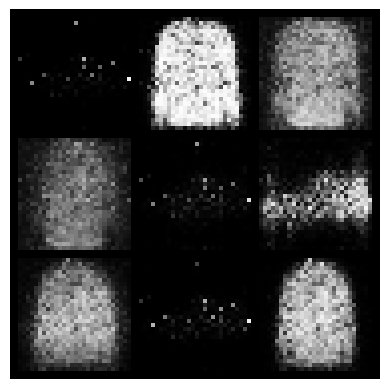

Starting epoch 13...
Step [0/938], d_loss: 0.0108, g_loss: 0.9900
Step [100/938], d_loss: 0.0104, g_loss: 0.9914
Step [200/938], d_loss: 0.0217, g_loss: 0.9296
Step [300/938], d_loss: 0.0314, g_loss: 0.9967
Step [400/938], d_loss: 0.0155, g_loss: 0.9931
Step [500/938], d_loss: 0.0078, g_loss: 0.9729
Step [600/938], d_loss: 0.0182, g_loss: 0.9767
Step [700/938], d_loss: 0.0243, g_loss: 0.9758
Step [800/938], d_loss: 0.0002, g_loss: 0.9970
Step [900/938], d_loss: 0.0013, g_loss: 0.9809
Epoch [13/30], d_loss: 0.0023, g_loss: 0.9914


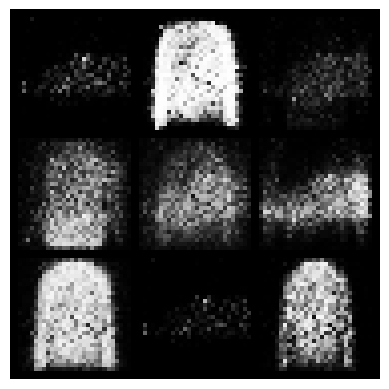

Starting epoch 14...
Step [0/938], d_loss: 0.0064, g_loss: 0.9927
Step [100/938], d_loss: 0.0372, g_loss: 0.9785
Step [200/938], d_loss: 0.0288, g_loss: 0.9995
Step [300/938], d_loss: 0.0036, g_loss: 0.9845
Step [400/938], d_loss: 0.0210, g_loss: 0.9980
Step [500/938], d_loss: 0.0179, g_loss: 0.9781
Step [600/938], d_loss: 0.0035, g_loss: 0.9967
Step [700/938], d_loss: 0.0167, g_loss: 0.9930
Step [800/938], d_loss: 0.0010, g_loss: 0.9783
Step [900/938], d_loss: 0.0009, g_loss: 0.9363
Epoch [14/30], d_loss: 0.0056, g_loss: 0.9979


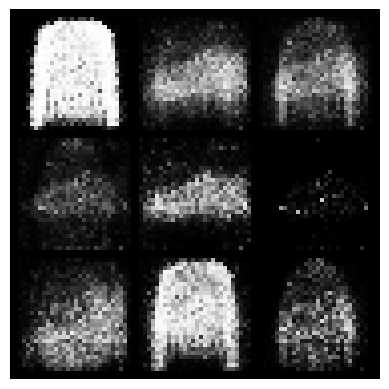

Starting epoch 15...
Step [0/938], d_loss: 0.0295, g_loss: 0.9678
Step [100/938], d_loss: 0.0051, g_loss: 0.9903
Step [200/938], d_loss: 0.0294, g_loss: 0.9995
Step [300/938], d_loss: 0.0055, g_loss: 0.9988
Step [400/938], d_loss: 0.0192, g_loss: 0.9738
Step [500/938], d_loss: 0.0211, g_loss: 0.9789
Step [600/938], d_loss: 0.0096, g_loss: 0.9755
Step [700/938], d_loss: 0.0005, g_loss: 0.9506
Step [800/938], d_loss: 0.0417, g_loss: 0.9602
Step [900/938], d_loss: 0.0257, g_loss: 0.9997
Epoch [15/30], d_loss: 0.0305, g_loss: 0.9936


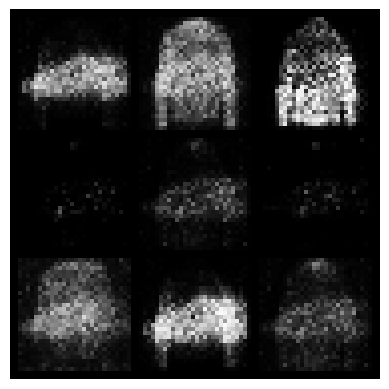

Starting epoch 16...
Step [0/938], d_loss: 0.0067, g_loss: 0.9592
Step [100/938], d_loss: 0.0175, g_loss: 0.9660
Step [200/938], d_loss: 0.0168, g_loss: 0.9972
Step [300/938], d_loss: 0.0135, g_loss: 0.9761
Step [400/938], d_loss: 0.0028, g_loss: 0.9356
Step [500/938], d_loss: 0.0094, g_loss: 0.9153
Step [600/938], d_loss: 0.0248, g_loss: 0.9991
Step [700/938], d_loss: 0.0052, g_loss: 0.9953
Step [800/938], d_loss: 0.0242, g_loss: 0.9759
Step [900/938], d_loss: 0.0144, g_loss: 0.9979
Epoch [16/30], d_loss: 0.0019, g_loss: 0.9902


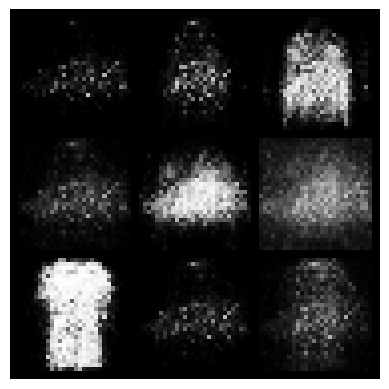

Starting epoch 17...
Step [0/938], d_loss: 0.0158, g_loss: 0.9244
Step [100/938], d_loss: 0.0039, g_loss: 0.9665
Step [200/938], d_loss: 0.0541, g_loss: 0.9502
Step [300/938], d_loss: 0.0280, g_loss: 0.9821
Step [400/938], d_loss: 0.0037, g_loss: 0.9587
Step [500/938], d_loss: 0.0394, g_loss: 0.9782
Step [600/938], d_loss: 0.0003, g_loss: 0.9729
Step [700/938], d_loss: 0.0337, g_loss: 0.9986
Step [800/938], d_loss: 0.0044, g_loss: 0.9926
Step [900/938], d_loss: 0.0153, g_loss: 0.9789
Epoch [17/30], d_loss: 0.0195, g_loss: 0.9918


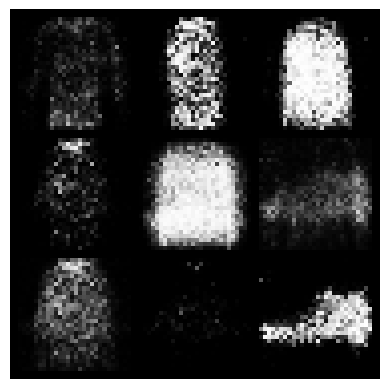

Starting epoch 18...
Step [0/938], d_loss: 0.0152, g_loss: 0.9953
Step [100/938], d_loss: 0.0243, g_loss: 0.9519
Step [200/938], d_loss: 0.0349, g_loss: 0.9764
Step [300/938], d_loss: 0.0298, g_loss: 0.9169
Step [400/938], d_loss: 0.0120, g_loss: 0.9374
Step [500/938], d_loss: 0.0161, g_loss: 0.9621
Step [600/938], d_loss: 0.0134, g_loss: 0.9597
Step [700/938], d_loss: 0.0061, g_loss: 0.9898
Step [800/938], d_loss: 0.0203, g_loss: 0.9976
Step [900/938], d_loss: 0.0503, g_loss: 0.9717
Epoch [18/30], d_loss: 0.0014, g_loss: 0.9904


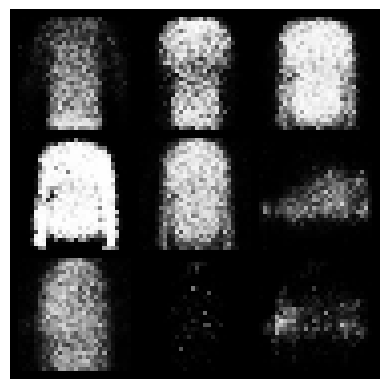

Starting epoch 19...
Step [0/938], d_loss: 0.0144, g_loss: 0.9684
Step [100/938], d_loss: 0.0251, g_loss: 0.9096
Step [200/938], d_loss: 0.0388, g_loss: 0.9807
Step [300/938], d_loss: 0.0008, g_loss: 0.9901
Step [400/938], d_loss: 0.0258, g_loss: 0.9691
Step [500/938], d_loss: 0.0025, g_loss: 0.9960
Step [600/938], d_loss: 0.0286, g_loss: 0.9991
Step [700/938], d_loss: 0.0153, g_loss: 0.9601
Step [800/938], d_loss: 0.0110, g_loss: 0.9677
Step [900/938], d_loss: 0.0287, g_loss: 0.9998
Epoch [19/30], d_loss: 0.0528, g_loss: 0.9907


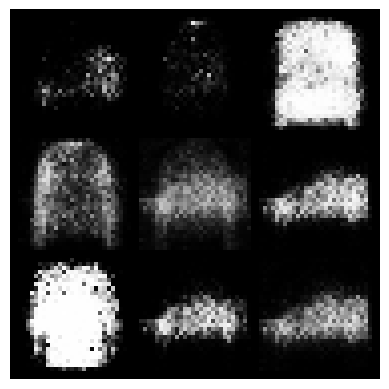

Starting epoch 20...
Step [0/938], d_loss: 0.0152, g_loss: 0.9818
Step [100/938], d_loss: 0.0076, g_loss: 0.9927
Step [200/938], d_loss: 0.0468, g_loss: 0.9905
Step [300/938], d_loss: 0.0321, g_loss: 0.9964
Step [400/938], d_loss: 0.0094, g_loss: 0.9504
Step [500/938], d_loss: 0.0613, g_loss: 0.9809
Step [600/938], d_loss: 0.0143, g_loss: 0.9127
Step [700/938], d_loss: 0.0220, g_loss: 0.9845
Step [800/938], d_loss: 0.0020, g_loss: 0.9856
Step [900/938], d_loss: 0.0276, g_loss: 0.9975
Epoch [20/30], d_loss: 0.0232, g_loss: 0.9958


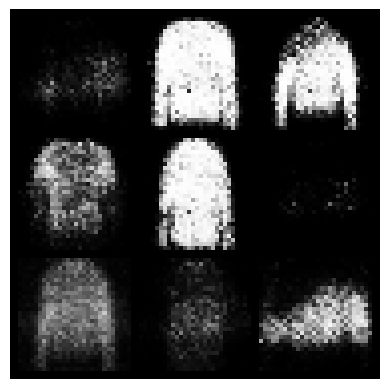

Starting epoch 21...
Step [0/938], d_loss: 0.0251, g_loss: 0.9839
Step [100/938], d_loss: 0.0167, g_loss: 0.9935
Step [200/938], d_loss: 0.0030, g_loss: 0.9889
Step [300/938], d_loss: 0.0340, g_loss: 0.9731
Step [400/938], d_loss: 0.0006, g_loss: 0.9987
Step [500/938], d_loss: 0.0177, g_loss: 0.9731
Step [600/938], d_loss: 0.0401, g_loss: 0.9874
Step [700/938], d_loss: 0.0306, g_loss: 0.9786
Step [800/938], d_loss: 0.0600, g_loss: 0.9711
Step [900/938], d_loss: 0.0185, g_loss: 0.8977
Epoch [21/30], d_loss: 0.0705, g_loss: 0.9416


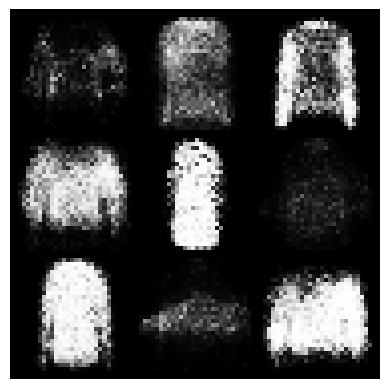

Starting epoch 22...
Step [0/938], d_loss: 0.0236, g_loss: 0.9863
Step [100/938], d_loss: 0.0393, g_loss: 0.9939
Step [200/938], d_loss: 0.0151, g_loss: 0.9649
Step [300/938], d_loss: 0.0162, g_loss: 0.9751
Step [400/938], d_loss: 0.0143, g_loss: 0.9742
Step [500/938], d_loss: 0.0425, g_loss: 0.9895
Step [600/938], d_loss: 0.0194, g_loss: 0.9314
Step [700/938], d_loss: 0.0308, g_loss: 0.8995
Step [800/938], d_loss: 0.0568, g_loss: 0.9983
Step [900/938], d_loss: 0.0014, g_loss: 0.9890
Epoch [22/30], d_loss: 0.0552, g_loss: 0.9633


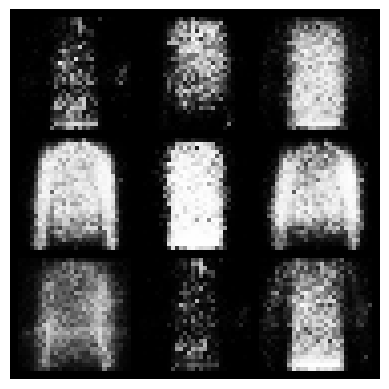

Starting epoch 23...
Step [0/938], d_loss: 0.0123, g_loss: 0.9262
Step [100/938], d_loss: 0.0139, g_loss: 0.9340
Step [200/938], d_loss: 0.0252, g_loss: 0.9171
Step [300/938], d_loss: 0.0308, g_loss: 0.9356
Step [400/938], d_loss: 0.0252, g_loss: 0.9561
Step [500/938], d_loss: 0.0412, g_loss: 0.9908
Step [600/938], d_loss: 0.0192, g_loss: 0.9416
Step [700/938], d_loss: 0.0316, g_loss: 0.9912
Step [800/938], d_loss: 0.0151, g_loss: 0.9852
Step [900/938], d_loss: 0.0135, g_loss: 0.9304
Epoch [23/30], d_loss: 0.0342, g_loss: 0.9996


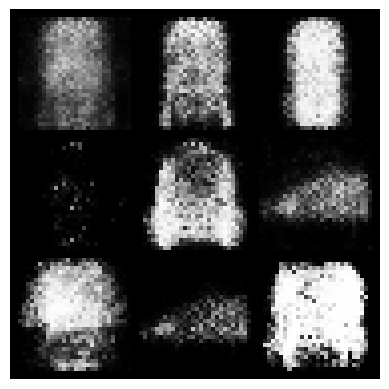

Starting epoch 24...
Step [0/938], d_loss: 0.0482, g_loss: 0.9923
Step [100/938], d_loss: 0.0118, g_loss: 0.9655
Step [200/938], d_loss: 0.0199, g_loss: 0.9778
Step [300/938], d_loss: 0.0481, g_loss: 0.9713
Step [400/938], d_loss: 0.0332, g_loss: 0.9924
Step [500/938], d_loss: 0.0320, g_loss: 0.9781
Step [600/938], d_loss: 0.0271, g_loss: 0.9446
Step [700/938], d_loss: 0.0268, g_loss: 0.9704
Step [800/938], d_loss: 0.0391, g_loss: 0.9953
Step [900/938], d_loss: 0.0233, g_loss: 0.9737
Epoch [24/30], d_loss: 0.0196, g_loss: 0.9952


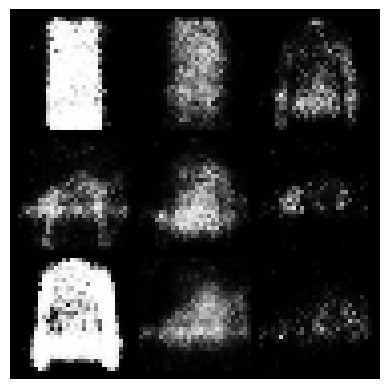

Starting epoch 25...
Step [0/938], d_loss: 0.0324, g_loss: 0.9470
Step [100/938], d_loss: 0.0205, g_loss: 0.9569
Step [200/938], d_loss: 0.0122, g_loss: 0.9804
Step [300/938], d_loss: 0.0578, g_loss: 0.9956
Step [400/938], d_loss: 0.0328, g_loss: 0.9754
Step [500/938], d_loss: 0.0342, g_loss: 0.9786
Step [600/938], d_loss: 0.0340, g_loss: 0.9597
Step [700/938], d_loss: 0.0201, g_loss: 0.9552
Step [800/938], d_loss: 0.0417, g_loss: 0.9951
Step [900/938], d_loss: 0.0263, g_loss: 0.9919
Epoch [25/30], d_loss: 0.0586, g_loss: 0.9333


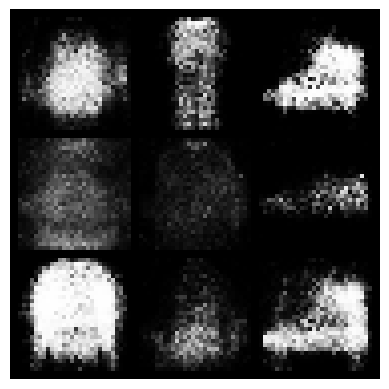

Starting epoch 26...
Step [0/938], d_loss: 0.0213, g_loss: 0.9729
Step [100/938], d_loss: 0.0125, g_loss: 0.9817
Step [200/938], d_loss: 0.0169, g_loss: 0.9611
Step [300/938], d_loss: 0.0253, g_loss: 0.9657
Step [400/938], d_loss: 0.0203, g_loss: 0.9947
Step [500/938], d_loss: 0.0279, g_loss: 0.9539
Step [600/938], d_loss: 0.0370, g_loss: 0.9474
Step [700/938], d_loss: 0.0065, g_loss: 0.9806
Step [800/938], d_loss: 0.0035, g_loss: 0.9213
Step [900/938], d_loss: 0.0085, g_loss: 0.9683
Epoch [26/30], d_loss: 0.0143, g_loss: 0.9761


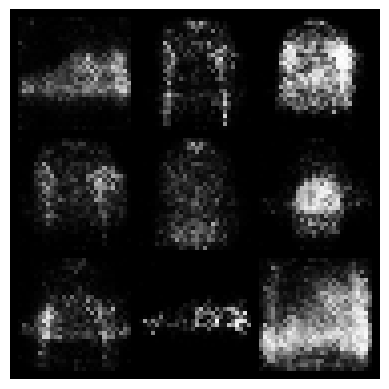

Starting epoch 27...
Step [0/938], d_loss: 0.0061, g_loss: 0.9371
Step [100/938], d_loss: 0.0510, g_loss: 0.9989
Step [200/938], d_loss: 0.0128, g_loss: 0.9666
Step [300/938], d_loss: 0.0188, g_loss: 0.9373
Step [400/938], d_loss: 0.0045, g_loss: 0.7726
Step [500/938], d_loss: 0.0225, g_loss: 0.9674
Step [600/938], d_loss: 0.0411, g_loss: 0.9961
Step [700/938], d_loss: 0.0029, g_loss: 0.9820
Step [800/938], d_loss: 0.0211, g_loss: 0.9550
Step [900/938], d_loss: 0.0047, g_loss: 0.9338
Epoch [27/30], d_loss: 0.0099, g_loss: 0.9414


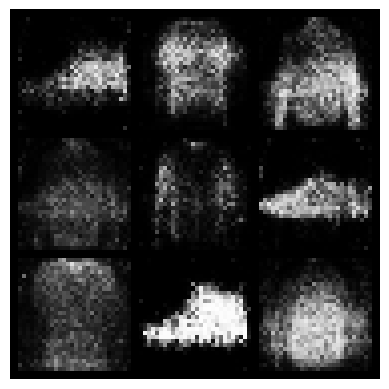

Starting epoch 28...
Step [0/938], d_loss: 0.0101, g_loss: 0.9934
Step [100/938], d_loss: 0.0251, g_loss: 0.9818
Step [200/938], d_loss: 0.0592, g_loss: 0.9737
Step [300/938], d_loss: 0.0164, g_loss: 0.9460
Step [400/938], d_loss: 0.0493, g_loss: 0.9738
Step [500/938], d_loss: 0.0208, g_loss: 0.9462
Step [600/938], d_loss: 0.0197, g_loss: 0.9921
Step [700/938], d_loss: 0.0238, g_loss: 0.9781
Step [800/938], d_loss: 0.0169, g_loss: 0.9851
Step [900/938], d_loss: 0.0080, g_loss: 0.9656
Epoch [28/30], d_loss: 0.0636, g_loss: 0.9872


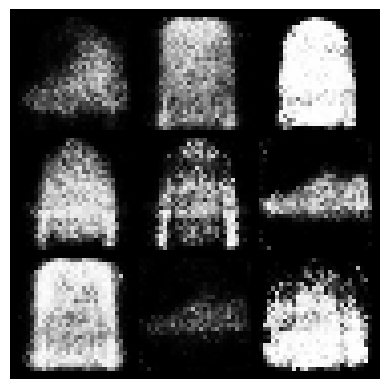

Starting epoch 29...
Step [0/938], d_loss: 0.0301, g_loss: 0.9172
Step [100/938], d_loss: 0.0135, g_loss: 0.9474
Step [200/938], d_loss: 0.0269, g_loss: 0.8413
Step [300/938], d_loss: 0.0459, g_loss: 0.9803
Step [400/938], d_loss: 0.0556, g_loss: 0.9514
Step [500/938], d_loss: 0.0277, g_loss: 0.9058
Step [600/938], d_loss: 0.0117, g_loss: 0.9481
Step [700/938], d_loss: 0.0212, g_loss: 0.9709
Step [800/938], d_loss: 0.0214, g_loss: 0.9619
Step [900/938], d_loss: 0.0442, g_loss: 0.9721
Epoch [29/30], d_loss: 0.0158, g_loss: 0.9797


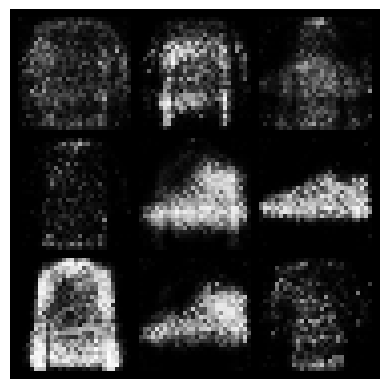

In [42]:
num_epochs = 30
n_critic = 5
display_step = 100

# 모델 저장 경로
generator_path = '../experiments/generator.pth'
discriminator_path = '../experiments/discriminator.pth'


for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.to(device)
        labels = labels.to(device)
        
        generator.train()
        batch_size = real_images.size(0)
        
        d_loss = discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels)
        
        #generator보다 critic(discriminator)을 더 자주 학습
        if i % n_critic == 0:
            g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
            
        
        if i % display_step == 0:
            print('Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(i, len(data_loader), d_loss, g_loss))
    
    generator.eval()
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch, num_epochs, d_loss, g_loss))
    
    with torch.no_grad():
        z = torch.randn(9, 100, device=device)
        labels = torch.arange(9, device=device)
        sample_images = generator(z, labels).unsqueeze(1).data.cpu()
        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
        
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

# Save model
torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)


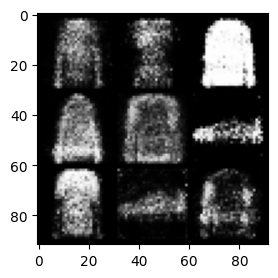

In [43]:
# Load pretrained Generator Model
generator = Generator().to(device)  # 적절한 Generator 클래스를 생성자로 사용해야 합니다.
generator.load_state_dict(torch.load(generator_path))
generator.eval()

z = torch.randn(9, 100).to(device)
labels = torch.LongTensor(np.arange(9)).to(device)
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

plt.figure(figsize=(3,3))
grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()

## EDA

- 화질 저하의 문제 발생
- 원본 데이터 자체의 화질 문제 or 생성된 데이터의 문제 

In [86]:
import matplotlib.pyplot as plt
import torch

def draw_image_graph(image_tensor):
    image_array = image_tensor.numpy()

    if image_array.shape[0] == 1:
        image_array = image_array.squeeze(0)

    fig, ax = plt.subplots()
    ax.imshow(image_array, cmap='gray')
    plt.show()

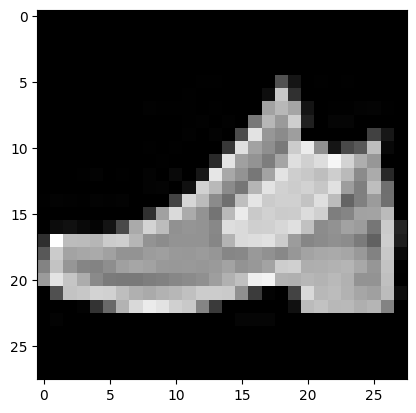

In [95]:
image_tensor = dataset[1][0]  # Assuming you have the image tensor
draw_image_graph(image_tensor)

원본 데이터도 뚜렷하지는 않지만, 생성된 데이터는 원본 데이터보다 화질이 안좋은 현상 발생

해결방법 찾아보기  ===> 1차적으로 generator train 시 discriminator와 동일하게 학습 진행

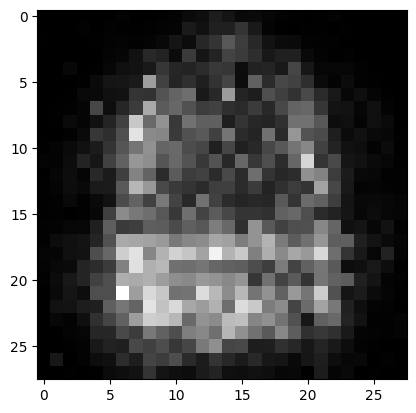

In [93]:
z = torch.randn(1, 100).to(device)
labels = torch.LongTensor(np.arange(1)).to(device)
sample_images = generator(z, labels).data.cpu()
sample_images.shape
draw_image_graph(sample_images)

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def perform_eda(generator, device):
    num_samples = 1000  # Number of images to generate

    with torch.no_grad():
        z = torch.randn(num_samples, 100, device=device)
        labels = torch.arange(num_samples, device=device)
        generated_images = generator(z, labels).unsqueeze(1).cpu()

    # Reshape the generated images for visualization
    generated_images = generated_images.view(-1, 28, 28)

    # Plot a random sample of generated images
    np.random.seed(42)
    random_indices = np.random.choice(num_samples, size=16, replace=False)
    sample_images = generated_images[random_indices]

    # Create a grid of the sample images
    grid = make_grid(sample_images, nrow=4, normalize=True).permute(1, 2, 0).numpy()

    # Plot the grid of sample images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.axis('off')
    plt.title('Generated Images (Sample)')
    plt.show()

    # Plot the class distribution of generated images
    generated_labels = labels.numpy()
    unique_labels, label_counts = np.unique(generated_labels, return_counts=True)

    plt.figure(figsize=(10, 5))
    plt.bar(unique_labels, label_counts)
    plt.xticks(unique_labels)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Class Distribution of Generated Images')
    plt.show()


In [99]:
perform_eda(generator, 'cpu')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [100]:
num_samples = 1000  # Number of images to generate
num_clusters = 10  # Number of clusters for k-means


# z = torch.randn(num_samples, 100, device=device)
# labels = torch.arange(num_samples, device=device)
# generated_images = generator(z, labels).unsqueeze(1).cpu()

z = torch.randn(num_samples, 100).to(device)
labels = torch.LongTensor(np.arange(num_samples)).to(device)
generated_images = generator(z, labels).unsqueeze(1).data.cpu()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# 아래부터 완성 X 실행안됨

## LSGAN 
- DCGAN의 loss를 least square로 사용한 GAN

In [7]:
workers = 2
batch_size = 32
image_size = 28

nc = 3 #이미지 channel 수


# Size of feature maps in generator

ndf = 64

lr = 0.0002
beta1 = 0.5

In [8]:
lsgan_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [9]:
nz = 100 # noise vector의 dimension
ngf = 64

class LSGAN_Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [10]:
class LSGAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
   
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [13]:
lsgan_generator = LSGAN_Generator().to(device)
lsgan_discriminator = LSGAN_Discriminator().to(device)

In [15]:
criterion = nn.MSELoss()
lsgan_d_optimizer = torch.optim.Adam(lsgan_discriminator.parameters(),lr=lr, betas=(beta1, 0.999))
lsgan_g_optimizer = torch.optim.Adam(lsgan_generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [89]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

In [ ]:
def lsgan_generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    
    #noise 생성
    z = torch.randn(batch_size, 100, device=device)
    
    #fake labels, images 생성
    fake_labels = torch.randint(0, 10, (batch_size,), device=device)
    fake_images = generator(z, fake_labels)
    
    # D(fake images)
    validity = discriminator(fake_images, fake_labels)
    
    #Generator의 목표 : D(G(z)) = 1 이므로 loss(D(G(z)), 1)
    g_loss = criterion(validity, torch.ones(batch_size, device=device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()


In [ ]:
def lsgan_discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size, device=device))

    # Train with fake images
    z = torch.randn(batch_size,  nz, 1, 1, device=device)
    fake_labels = torch.randint(0, 10, (batch_size,), device=device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size, device=device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()


In [ ]:
num_epochs = 10

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    
    for i, (images, labels) in enumerate(lsgan_dataloader, 0):

        lsgan_discriminator.zero_grad()

        real_images = images.to(device)
        labels = labels.to(device)

        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        output = lsgan_discriminator(real_images).view(-1)
        errD_real = criterion(output,  torch.ones(batch_size, device=device))
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = lsgan_generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = lsgan_discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()


        lsgan_generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = lsgan_discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = lsgan_generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()